In [1]:
# Verileri toplamak için duckduckgo_search indirelim
!pip install -Uqq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
# ddg_images ne kadar iyi sonuçlar veriyor diye bakalım.
urls = search_images('lion photos', max_images=1)
urls[0]

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://greatzoo.org/media/library/fluid-ext-editor-widget/64/image/AdobeStock_59396481.jpeg?23'

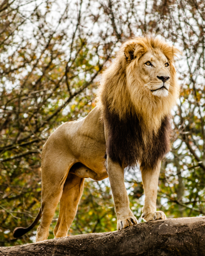

In [4]:
from fastdownload import download_url
dest = 'lion.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


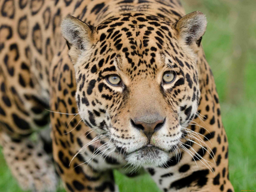

In [5]:
# araba markası olan jaguar da var arada karışmaması için animal jaguar diye arattım.
download_url(search_images('animal jaguar photos', max_images=1)[0], 'jaguar.jpg', show_progress=False)
Image.open('jaguar.jpg').to_thumb(256,256)

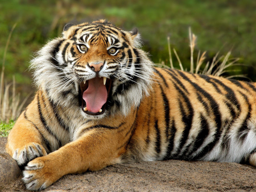

In [6]:
download_url(search_images('tiger photos', max_images=1)[0], 'tiger.jpg', show_progress=False)
Image.open('tiger.jpg').to_thumb(256,256)

In [7]:
searches = 'lion','jaguar', 'tiger'
path = Path('lion_jaguar_tiger')
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'animal {o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [8]:
# bazı fotoğraflar tam indirilmemiş olabilir onları aradan çıkartalım
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

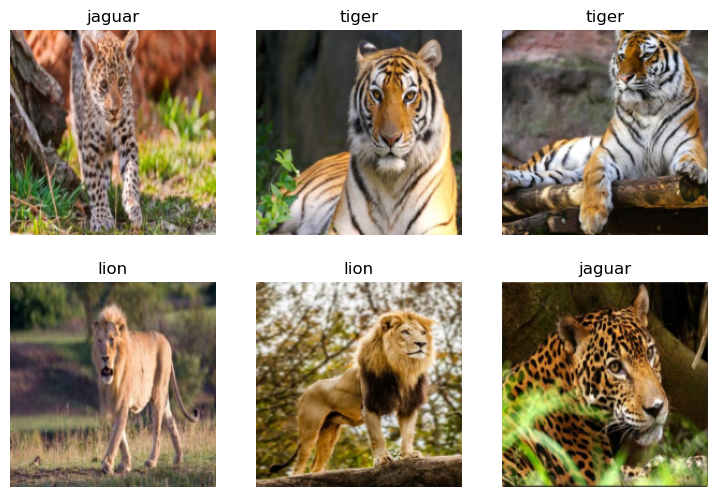

In [9]:
# Modeli oluşturmak için DataLoaders a ihtiyacımız var onu oluşturalım.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
# Veri setinden birkaç örnek görelim
dls.show_batch(max_n=6)

In [10]:
# Modelimizi oluşturalım, hızlı olması bakımından resnet18 fine-tune edip kullanalım.
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.779834,0.077687,0.019231,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.282378,0.010413,0.000000,00:03
1,0.161409,0.000660,0.000000,00:02
2,0.112061,0.000494,0.000000,00:02


In [26]:
# şimdi ise başta indirdiğimiz resimleri modelimize tahmin ettirelim.

def predict(image_name):
    pred_name,_,_ = learn.predict(PILImage.create(image_name))
    print(f"Bu bir: {pred_name}")

Bu bir: lion


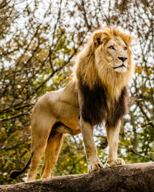

In [27]:
predict("lion.jpg")
Image.open("lion.jpg").to_thumb(192,192)

Bu bir: jaguar


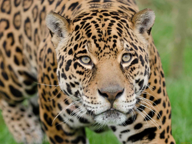

In [28]:
predict("jaguar.jpg")
Image.open("jaguar.jpg").to_thumb(192,192)

Bu bir: tiger


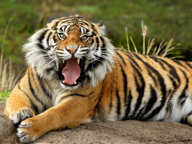

In [29]:
predict("tiger.jpg")
Image.open("tiger.jpg").to_thumb(192,192)